**Creator: Engin Deniz Alpman**

# Deep Learning

You can approach majority of your problems that you have encountered with tree based algorithms and neural nets ! But forests have a downside, they are not good at extrapolationg to the points that they haven't seen.

Random Forest cannot extrapolate but neural networks can, they are universal function approximators(explain that).

We will start applying neural networks to unstructured data, in our case we will start with digit recognition, and then we will see neural networks can be applied to tabular data as well!

## About The Data

Solution to this problem can be used by,for example, by banks to recognize the hand written number etc

In computers, everything is represented as a number. In our example, pixels of an image can be represented as an array of numbers

* In the first lecture we will just try to classify 3 vs 5. In the following lecture we will extend our knowledge to do multiclass classification for the numbers 0...9

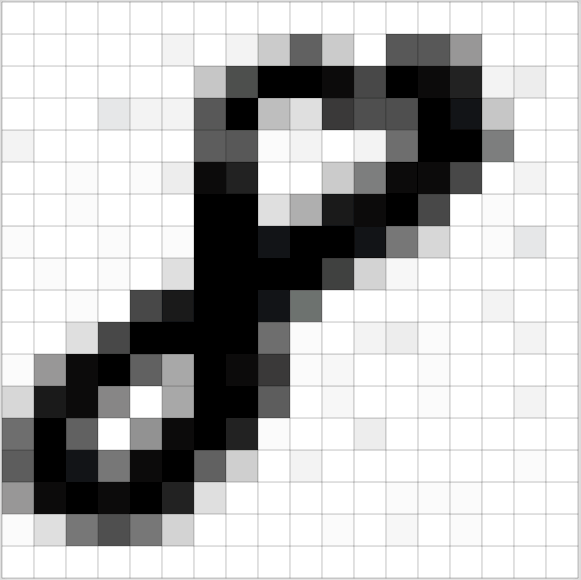

**Our objective is to look at this array of numbers and say this number is 3 etc**

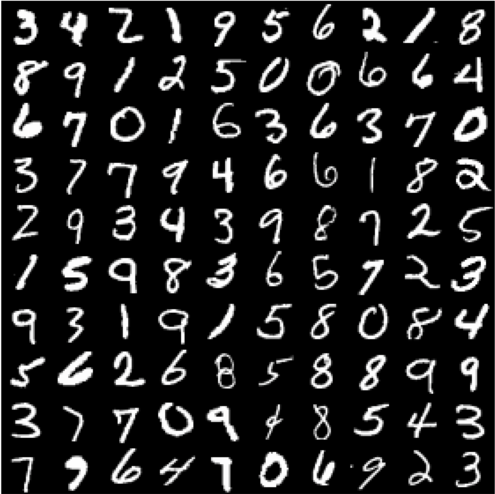

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

In [3]:
import math

In [4]:
PATH= Path('data/mnist/')

## Opening an image

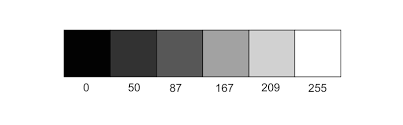

In [5]:
image = Image.open("img_1.jpg")

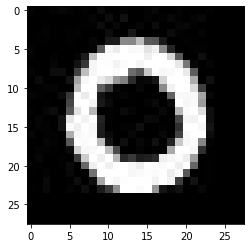

In [6]:
plt.imshow(image, cmap='gray')

In [7]:
np.array(image).shape

(28, 28)

## To see it as an array of number:

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(np.array(image))

In [10]:
df.style.set_properties().background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,3,0,0,3,7,3,0,3,0,11,0,0,3,0,0,3,8,0,0,3,0,0,0,2,0,0,0,0
1,0,0,0,0,0,0,0,1,5,0,12,0,16,0,0,4,0,2,8,3,0,4,8,0,0,0,0,0
2,0,0,2,0,0,0,1,2,1,12,0,8,0,0,6,0,11,0,0,6,7,2,0,0,0,0,0,0
3,0,1,3,0,0,2,3,0,0,0,12,0,0,23,0,0,0,0,11,3,0,0,4,0,0,0,0,0
4,0,1,1,0,0,2,0,0,6,0,25,27,136,135,188,89,84,25,0,0,3,1,0,0,0,0,0,0
5,4,0,0,0,0,0,0,0,3,88,247,236,255,249,250,227,240,136,37,1,0,2,2,0,0,0,0,0
6,2,0,0,3,0,0,4,27,193,251,253,255,255,255,255,240,254,255,213,89,0,0,14,1,0,0,0,0
7,0,0,0,6,0,0,18,56,246,255,253,243,251,255,245,255,255,254,255,231,119,7,0,5,0,0,0,0
8,4,0,0,12,13,0,65,190,246,255,255,251,255,109,88,199,255,247,250,255,234,92,0,0,0,0,0,0
9,0,10,1,0,0,18,163,248,255,235,216,150,128,45,6,8,22,212,255,255,252,172,0,15,0,0,0,0


## Baseline

* To know how good we are doing often requires baseline. Baseline should be a model that is easy to implement and better than random guessing. 



* You can create complicated looking models that have good accururacy etc. but at the end of the day, maybe just putting mean of all the data as a guess will have higher accuracy. So we need a baseline to check if we are really doing better than the simplest model that we can think of

* How can we create baseline for classifying 3 or 5 ? 

* We can take the mean of all the pixels in images of 3 and 5, then average them. What we will get is 28x28 values for the means of images of 3 and 28x28 values for the images of 5. You can think them as on average that is how 3 looks like or 5 looks like

* Then when we have a image to classify, we will calculate the distance between pixels to decide if that is more similar to 3 or 5 one

## Creating list of images from folders

In [11]:
list(PATH.iterdir())

[WindowsPath('data/mnist/train'), WindowsPath('data/mnist/validation')]

In [12]:
Path.ls = lambda x: list(x.iterdir())

In [13]:
(PATH/"train").ls()

[WindowsPath('data/mnist/train/0'),
 WindowsPath('data/mnist/train/1'),
 WindowsPath('data/mnist/train/2'),
 WindowsPath('data/mnist/train/3'),
 WindowsPath('data/mnist/train/4'),
 WindowsPath('data/mnist/train/5'),
 WindowsPath('data/mnist/train/6'),
 WindowsPath('data/mnist/train/7'),
 WindowsPath('data/mnist/train/8'),
 WindowsPath('data/mnist/train/9')]

In [14]:
(PATH/"train/3").ls()

[WindowsPath('data/mnist/train/3/img_10829.jpg'),
 WindowsPath('data/mnist/train/3/img_10844.jpg'),
 WindowsPath('data/mnist/train/3/img_10860.jpg'),
 WindowsPath('data/mnist/train/3/img_10866.jpg'),
 WindowsPath('data/mnist/train/3/img_10868.jpg'),
 WindowsPath('data/mnist/train/3/img_10876.jpg'),
 WindowsPath('data/mnist/train/3/img_10889.jpg'),
 WindowsPath('data/mnist/train/3/img_10893.jpg'),
 WindowsPath('data/mnist/train/3/img_10896.jpg'),
 WindowsPath('data/mnist/train/3/img_10900.jpg'),
 WindowsPath('data/mnist/train/3/img_10909.jpg'),
 WindowsPath('data/mnist/train/3/img_10921.jpg'),
 WindowsPath('data/mnist/train/3/img_10929.jpg'),
 WindowsPath('data/mnist/train/3/img_10930.jpg'),
 WindowsPath('data/mnist/train/3/img_10936.jpg'),
 WindowsPath('data/mnist/train/3/img_10937.jpg'),
 WindowsPath('data/mnist/train/3/img_10964.jpg'),
 WindowsPath('data/mnist/train/3/img_10965.jpg'),
 WindowsPath('data/mnist/train/3/img_10994.jpg'),
 WindowsPath('data/mnist/train/3/img_11010.jpg'),


In [15]:
Image.open((PATH/"train/3").ls()[0])

### Creating images list for three and two

In [16]:
three =[torch.tensor(np.array(Image.open(img)), dtype = torch.float32) for img in (PATH/"train/3").ls()]

In [17]:
two =[torch.tensor(np.array(Image.open(img)), dtype = torch.float32) for img in (PATH/"train/2").ls()]

### Looking at the images in our lists

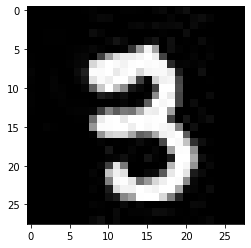

In [430]:
plt.imshow(three[0], cmap = "gray");

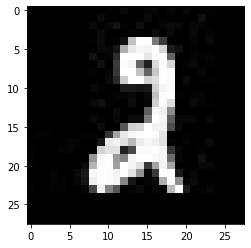

In [431]:
plt.imshow(two[0], cmap = "gray");

### We will calculate the mean of the images that belong to the same group so we will stack them and create new dimension

* We know that maximum value of the pixel can be 255, we can divide by that number to normalize our inputs

In [432]:
two_stacked = torch.stack(two) / 255

In [433]:
two_stacked.shape

torch.Size([3089, 28, 28])

In [434]:
three_stacked = torch.stack(three) / 255

In [435]:
three_stacked.shape

torch.Size([3263, 28, 28])

### Creating lists for validation

In [440]:
valid_3 =torch.stack([torch.tensor(np.array(Image.open(img)), dtype = torch.float32) for img in (PATH/"validation/3").ls()])

In [441]:
valid_2 =torch.stack([torch.tensor(np.array(Image.open(img)), dtype = torch.float32) for img in (PATH/"validation/2").ls()])

## Now we need to calculate each pixel's average across all the images at the same group

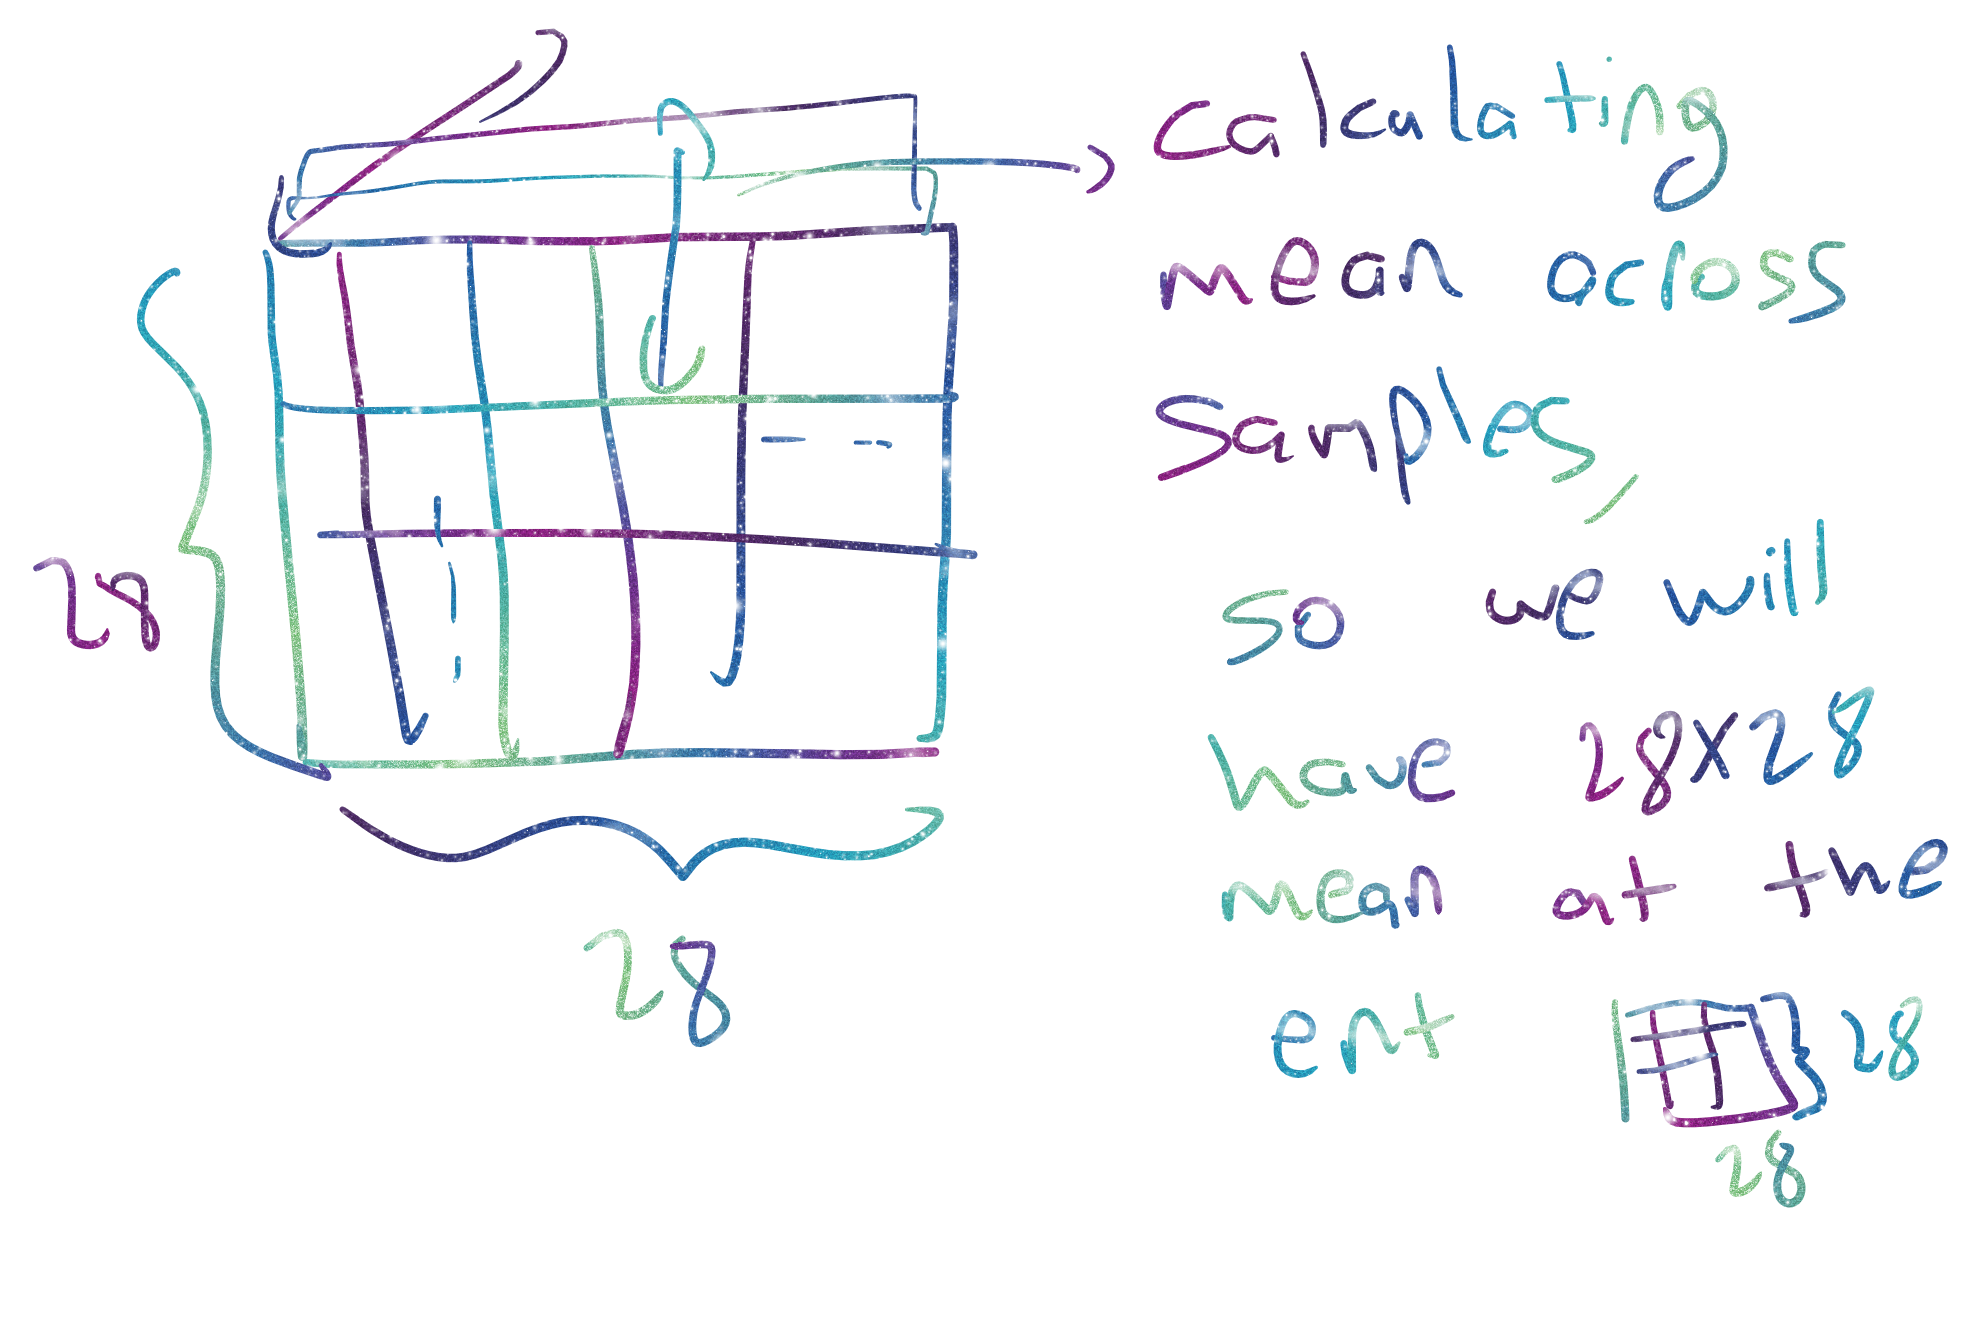

In [442]:
avr3 = three_stacked.mean(0)

In [443]:
avr2 = two_stacked.mean(0)

## Viewing how average images look

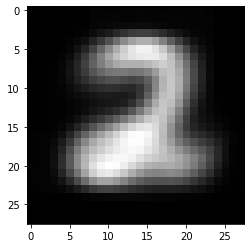

In [444]:
plt.imshow(avr2, cmap = "gray");

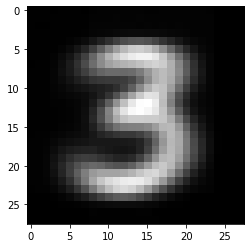

In [445]:
plt.imshow(avr3, cmap = "gray");

## We will try to find if  arbitrary 3 we chose from list is more similar to avr3 or avr7

In [446]:
sample_3 = three_stacked[20]

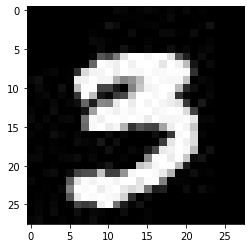

In [447]:
plt.imshow(sample_3, cmap = "gray");

In [448]:
dist_to_3 = ((sample_3 - avr3)**2).mean().sqrt()

In [449]:
dist_to_2 = ((sample_3 - avr2)**2).mean().sqrt()

In [450]:
dist_to_3.item()

0.2662103474140167

In [451]:
dist_to_2.item()

0.34839385747909546

###  We want some to find generic function that says the image we are feeding is more similar to 3 or 5

In [452]:
def distance(a, b):
    return ((a - b)**2).mean((-1,-2)).sqrt()

In [453]:
distance(sample_3, avr3)

tensor(0.2662)

* We want to do that in the whole data, we will do that using broadcasting

In [454]:
valid_dist_3 = distance(three_stacked, avr3)
valid_dist_3, valid_dist_3.shape

(tensor([0.2515, 0.2128, 0.1926,  ..., 0.3110, 0.1956, 0.2075]),
 torch.Size([3263]))

In [455]:
def is_three(x):
    return distance(x, avr3) < distance(x, avr2)

In [456]:
is_three(sample_3)

tensor(True)

In [457]:
is_three(valid_3)

tensor([ True,  True,  True,  ...,  True, False,  True])

In [458]:
accuracy_3 = is_three(valid_3).float().mean()
accuracy_3

tensor(0.9357)

In [459]:
accuracy_2 = (1 - is_three(valid_2).float()).mean()
accuracy_2

tensor(0.9283)

In [460]:
(accuracy_3 + accuracy_2) / 2

tensor(0.9320)

* So our baseline model's accuracy is 0.93, so we will try to find better model than that

## Different Model - Assigning Weights

* We can change our perspective and instead of calculating the distances between avr shapes and samples, we can look at individual pixels and assign weights for each of them. Previously we were assigning same weights to the pixels

28*28 = 784

* Weight vector and our sample images have length of 784 (1 for every pixels), so that every pixel will have corresponding weights. We will try to find values of ``w`` which will cause ``(x*w).sum()`` to be high for actual images, and low for other images of different categories. For example weights of the middle part of the "3"s can be low since we expect not to see high activation on those part. But we will not say that to our model, our model will find that patterns from data with updating its weights

### Tensor's Grad

* Pytorch can keep track of the tensor for which calculation it went through, and can calculate the derivative for us.

In [461]:
x = torch.tensor(2.).requires_grad_()

* We will call a function on it

In [462]:
def f(x):
    return x**2

In [463]:
grad = f(x)

* Calculating the gradient

In [464]:
grad.backward()

In [465]:
x.grad

tensor(4.)

### Creating Training and Validation Set

#### view()

* view() function is for reshaping our tensors

In [466]:
a = torch.tensor([1,2,3,4,5,6])

In [467]:
a

tensor([1, 2, 3, 4, 5, 6])

In [468]:
a.view(2, 3)

tensor([[1, 2, 3],
        [4, 5, 6]])

* We can also use -1 to infer that dimension from other ones. It is like, tensor **a** has 6 elements in total, so if we say a.view(-1,2), it will be same as a.view(3,2), it is infering 3 to match the total size of 6

In [469]:
a.view(-1,2)

tensor([[1, 2],
        [3, 4],
        [5, 6]])

#### Creating training and validation set

* We will create labels, so we will say images of 3 ->1 and images of 2 ->0 

In [470]:
# To check labels and mappings later. It has no practical usage
labels = {1:"Three", 0:"Two"}

In [471]:
train_x = torch.cat([three_stacked, two_stacked]).view(-1, 28*28)

In [472]:
train_y = torch.tensor([1] * len(three) + [0] * len(two))

In [473]:
train_y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [474]:
# there are 6352 different images in training set
train_x.shape, train_y.shape

(torch.Size([6352, 784]), torch.Size([6352]))

In [475]:
train_y.unsqueeze_(-1)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [476]:
train_y.shape

torch.Size([6352, 1])

In [477]:
train_y # This is what PyTorch expects to see

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [478]:
valid_x = torch.cat([valid_3, valid_2]).view(-1, 28*28)

In [479]:
# Assume "a" is a pytorch tensor
# len(a) will return the first dimension 
valid_y = torch.tensor([1] * len(valid_3) + [0] * len(valid_2))

In [480]:
valid_y.shape

torch.Size([2176])

In [481]:
valid_y.unsqueeze(0)

tensor([[1, 1, 1,  ..., 0, 0, 0]])

In [482]:
valid_y.unsqueeze(0).shape

torch.Size([1, 2176])

In [483]:
valid_y.unsqueeze(1)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [484]:
valid_y.unsqueeze(1).shape

torch.Size([2176, 1])

In [485]:
valid_y = valid_y.unsqueeze(1)

### Creating Basic Dataset

* We will crete more generic version later, but this will do the work for just now

* The basic idea of Dataset is to have data and corresponding label(data, label) at the same place

#### zip function

* zip will match corresponding elements and create tuple from them

In [486]:
a = [1, 2, 3, 4]

In [487]:
b = ["a", "b", "c", "d"]

In [488]:
for i, j in zip(a,b):
    print(i,j)

1 a
2 b
3 c
4 d


In [489]:
list(zip(a,b))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

#### Creating dataset

In [490]:
ds_train = list(zip(train_x, train_y))

In [491]:
ds_valid = list(zip(valid_x, valid_y))

In [492]:
ds_train[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0118,
         0.0000, 0.0000, 0.0000, 0.0078, 0.0078, 0.0039, 0.0000, 0.0196, 0.0353,
         0.0000, 0.0235, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0118, 0.0314, 0.0275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0196, 0.0000, 0.0000, 0.0314, 0.0510, 0.0196, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0235, 0.0314, 0.0118,
         0.0431, 0.0275, 0.0314, 0.0392, 0.0000, 0.0392, 0.0078, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0039, 0.0000,
         0.0000, 0.0000, 0.0471, 0.0196, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0471, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

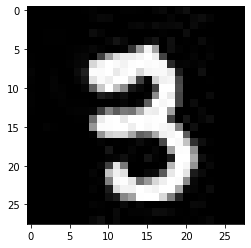

In [493]:
plt.imshow(ds_train[0][0].view(28,28), cmap="gray");

In [494]:
labels[ds_train[0][1].item()]

'Three'

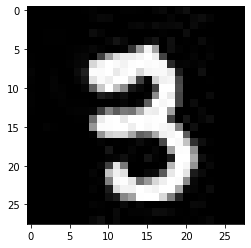

In [495]:
plt.imshow(ds_train[0][0].view(28,28), cmap="gray");

In [496]:
labels[ds_valid[0][1].item()]

'Three'

* Or we can do that with class

In [497]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i],self.y[i]

In [498]:
ds_train = Dataset(train_x, train_y)

In [499]:
ds_train[2]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0275, 0.0196, 0.0157, 0.0000,
         0.0039, 0.0275, 0.0000, 0.0000, 0.0314, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0549, 0.0000, 0.0000, 0.0353, 0.0510, 0.0235, 0.0000, 0.0000, 0.0000,
         0.0510, 0.0000, 0.0000, 0.0431, 0.0039, 0.0000, 0.0392, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0196, 0.0902, 0.0000, 0.0000, 0.0235, 0.0392, 0.0510,
         0.0118, 0.0000, 0.0196, 0.0039, 0.0000, 0.0078, 0.0471, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0706, 0.0000, 0.0118, 0.0039, 0.0431, 0.0431, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0392, 0.0157, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [500]:
ds_valid = Dataset(valid_x, valid_y)

In [501]:
train_x.shape

torch.Size([6352, 784])

In [502]:
valid_x.shape

torch.Size([2176, 784])

### Initializing Parameters

* Now that we have our dataset, we need our parameters to do the calculation

* Any variables that model will update in learning process are  **parameter**s

In [503]:
torch.randn(5)

tensor([ 2.7907, -0.4679, -0.9882, -0.5713, -0.3394])

In [504]:
torch.randn(5,2)

tensor([[ 0.6545,  0.1200],
        [-0.1646, -0.3096],
        [-0.0048, -0.6749],
        [-0.7594, -1.5175],
        [ 0.2437,  0.3545]])

* ``requires_grad_`` one is inplace  ``requires_grad`` is not

In [514]:
def init(size):
    return torch.randn(size, dtype=torch.float32).requires_grad_()

In [515]:
w = init((28*28,1))

In [516]:
w.shape

torch.Size([784, 1])

* We have initialized our weights corresponding each pixels, but they are not enough. They are scaled by the inputs, we need a parameter that is independent of inputs to have more flexibility (explain it more detailed)

In [517]:
b = init(1)

In [518]:
train_x[0].shape

torch.Size([784])

In [519]:
w.shape

torch.Size([784, 1])

In [520]:
(train_x[0] * w.T).sum() + b

tensor([-1.6118], grad_fn=<AddBackward0>)

### Making prediction with our untrained model

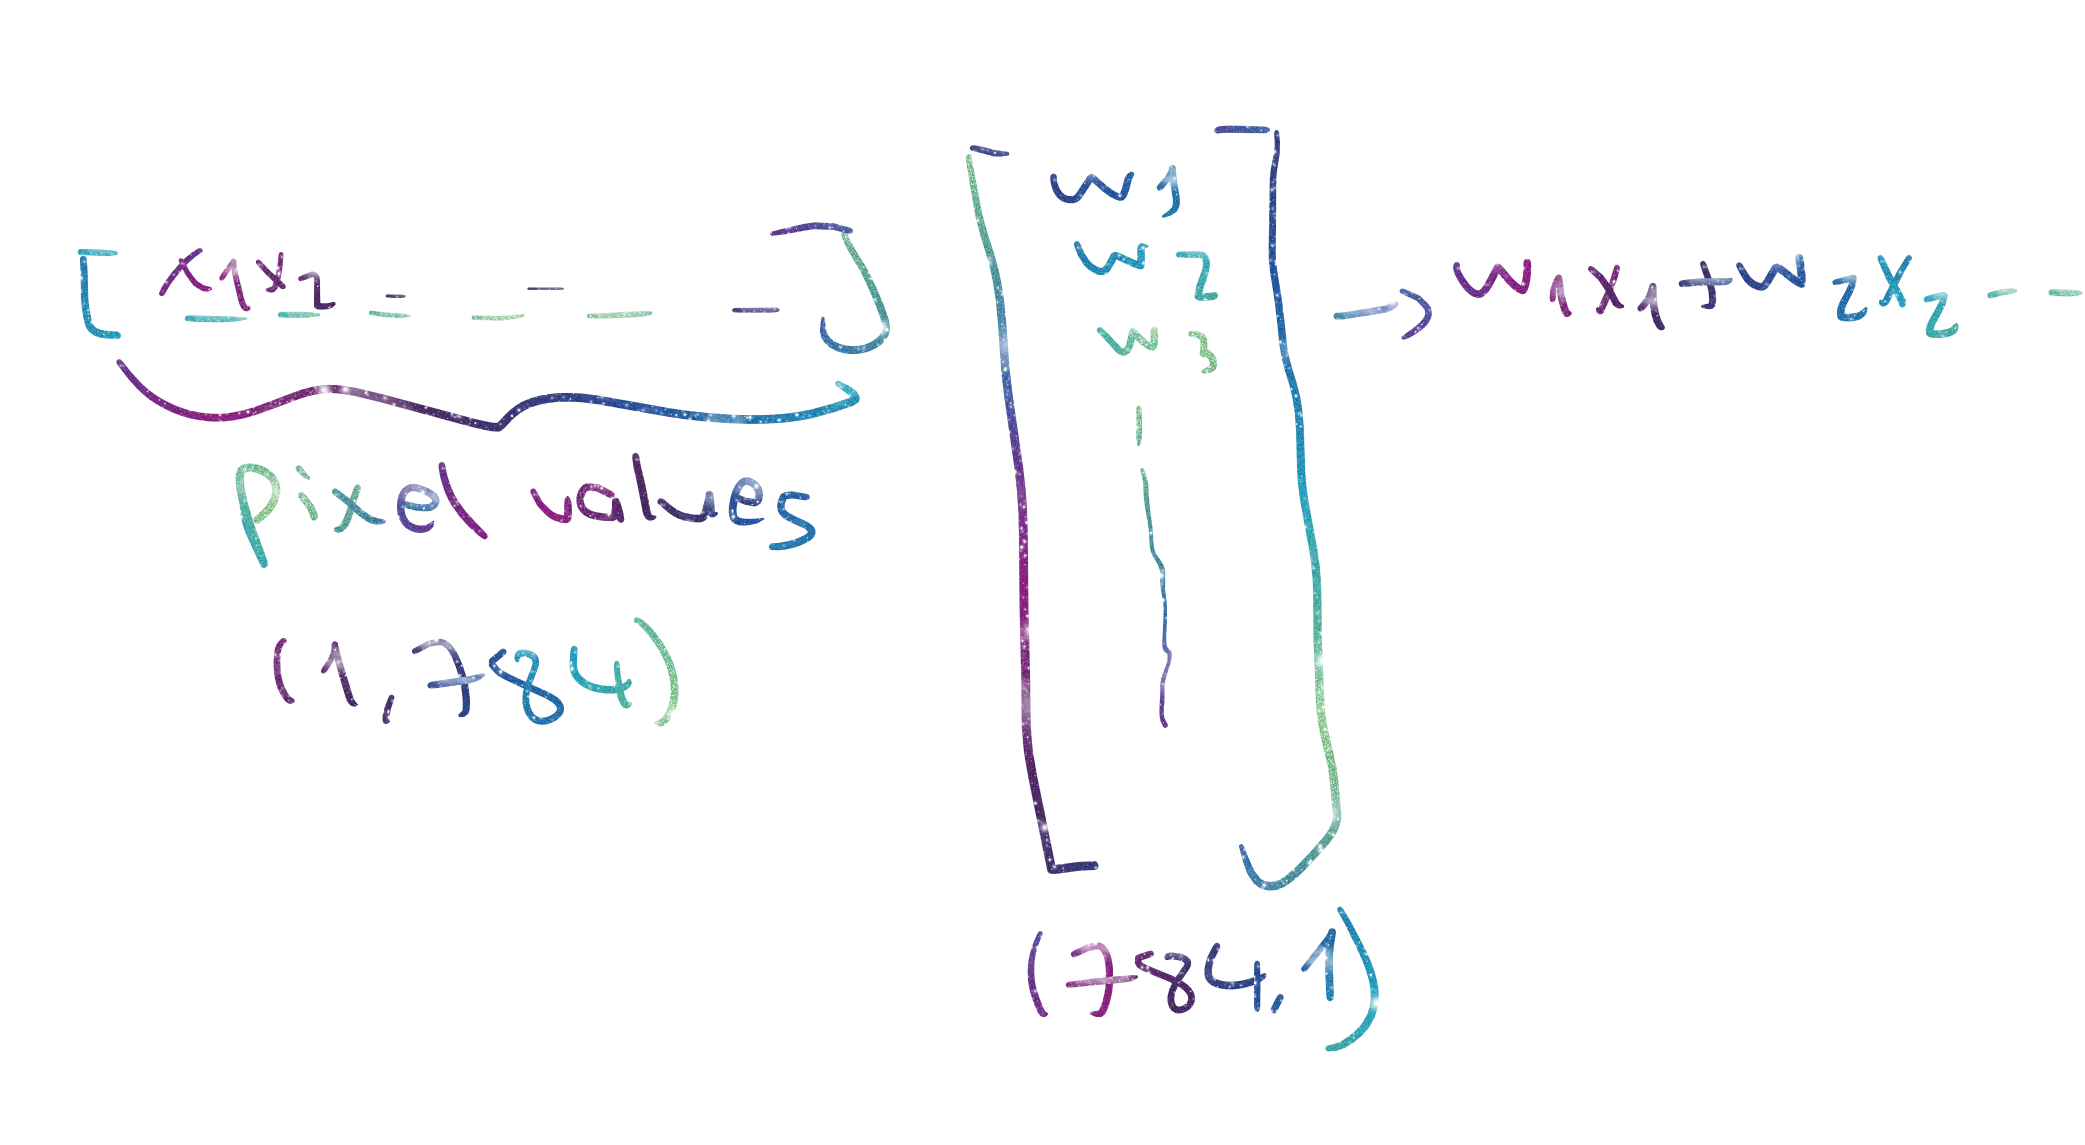

In [521]:
def linear_layer(xb):
    return xb @ w + b

In [522]:
preds = linear_layer(train_x)

In [523]:
preds.shape

torch.Size([6352, 1])

In [524]:
def accuracy(preds, actuals):
    return ((preds > 0.0).float() == actuals).float().mean().item()

In [525]:
accuracy(preds, train_y)

0.2811712920665741

### Calculating partial derivative

* To find how changing one parameter is affecting the result, we can literally change that variable and see the difference in result

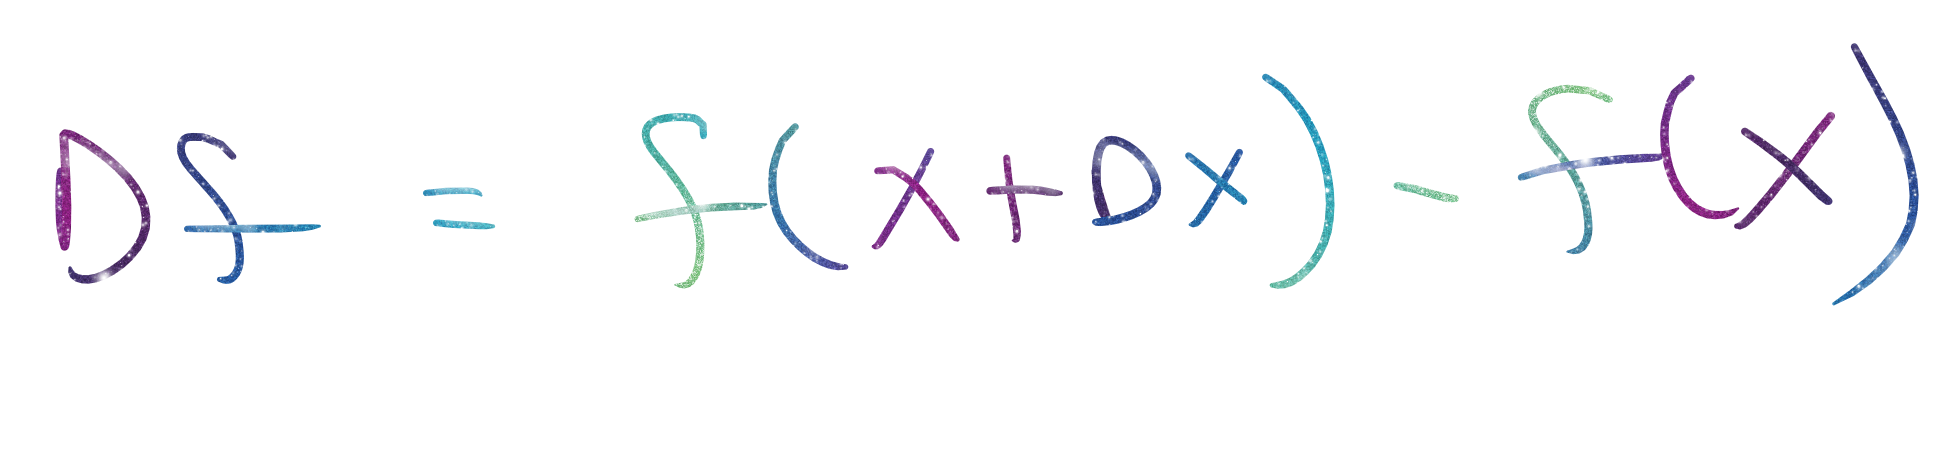

In [526]:
w[0] = w[0] * 1.0001

In [527]:
preds = linear_layer(train_x)

In [528]:
accuracy(preds, train_y)

0.2811712920665741

* Accuracy is same, because changing only one pixel's weight a tiny bit did not change the accuracy (it does not have enough influence in changing prediction from 3 to 2 etc)

* We should choose our loss function different than accuracy, because it only changes when prediction changes and we need to update our weights more easily. So gradient is almost always zero if we choose accuracy as our loss function

* So what should we choose for our loss function ? Loss function will receive not our inputs, it will receive our predictions and will decide how good we are at predicting. You can think it as error. The lower the value of loss function the better. It will say us the difference betweeen our predictions and actual values

* Our actual outputs will be 0 and 1. So we will write a function that calculates the difference between our predictions and the real values

* We will try to use pytorch functions as they are faster than writing loops etc in pure python

In [529]:
def loss(preds, targets):
    return torch.where(targets==1, 1-preds, preds).mean()

In [530]:
target_i = torch.tensor([1,1,0])
preds_i = torch.tensor([0.7,0.5,0.2])

In [531]:
loss(preds_i, target_i)

tensor(0.3333)

* Our loss function is returning lower values when our predictions are closer to the targets, and changing our parameters will affect the loss even if the prediction itself is unchanged !

In [532]:
preds_i = torch.tensor([0.7,0.5,0.4]) # I updated 0.2 to 0.4, they are both the same prediction but we will see the effect on loss 

In [533]:
loss(preds_i, target_i)

tensor(0.4000)

* But we have a problem again, it only works properly when we have our prediction between 0 and 1

* So we need to make our predictions between 0 and 1 if we are to use this loss function (later we will see that choosing sigmoid is not a must for other loss functions but since it makes our model's work easier, we will be using it)

### Function that maps any values to (0,1)

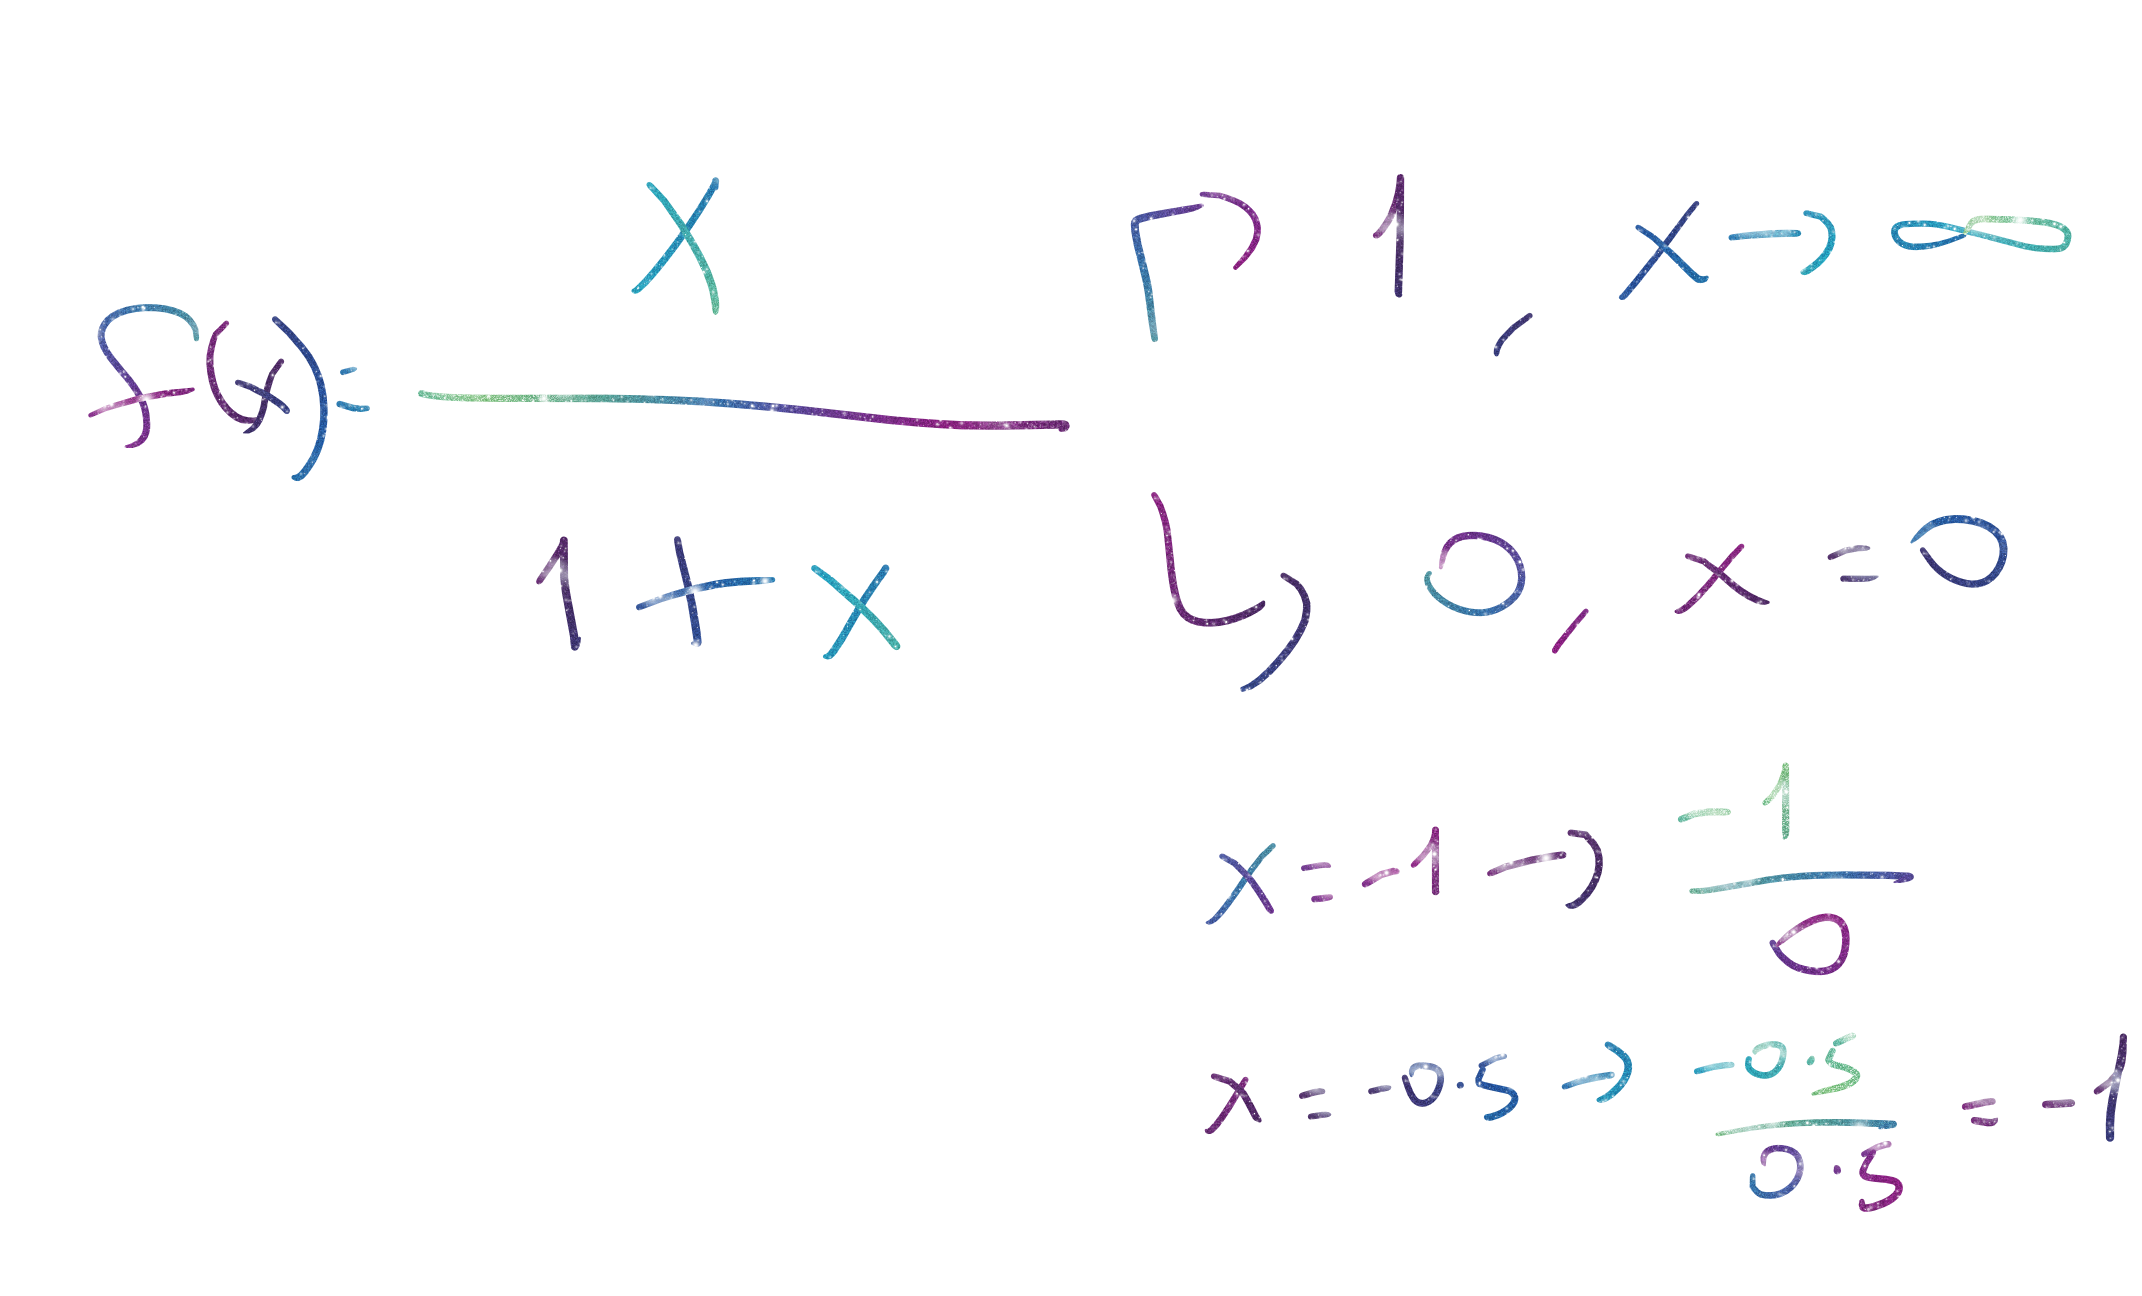

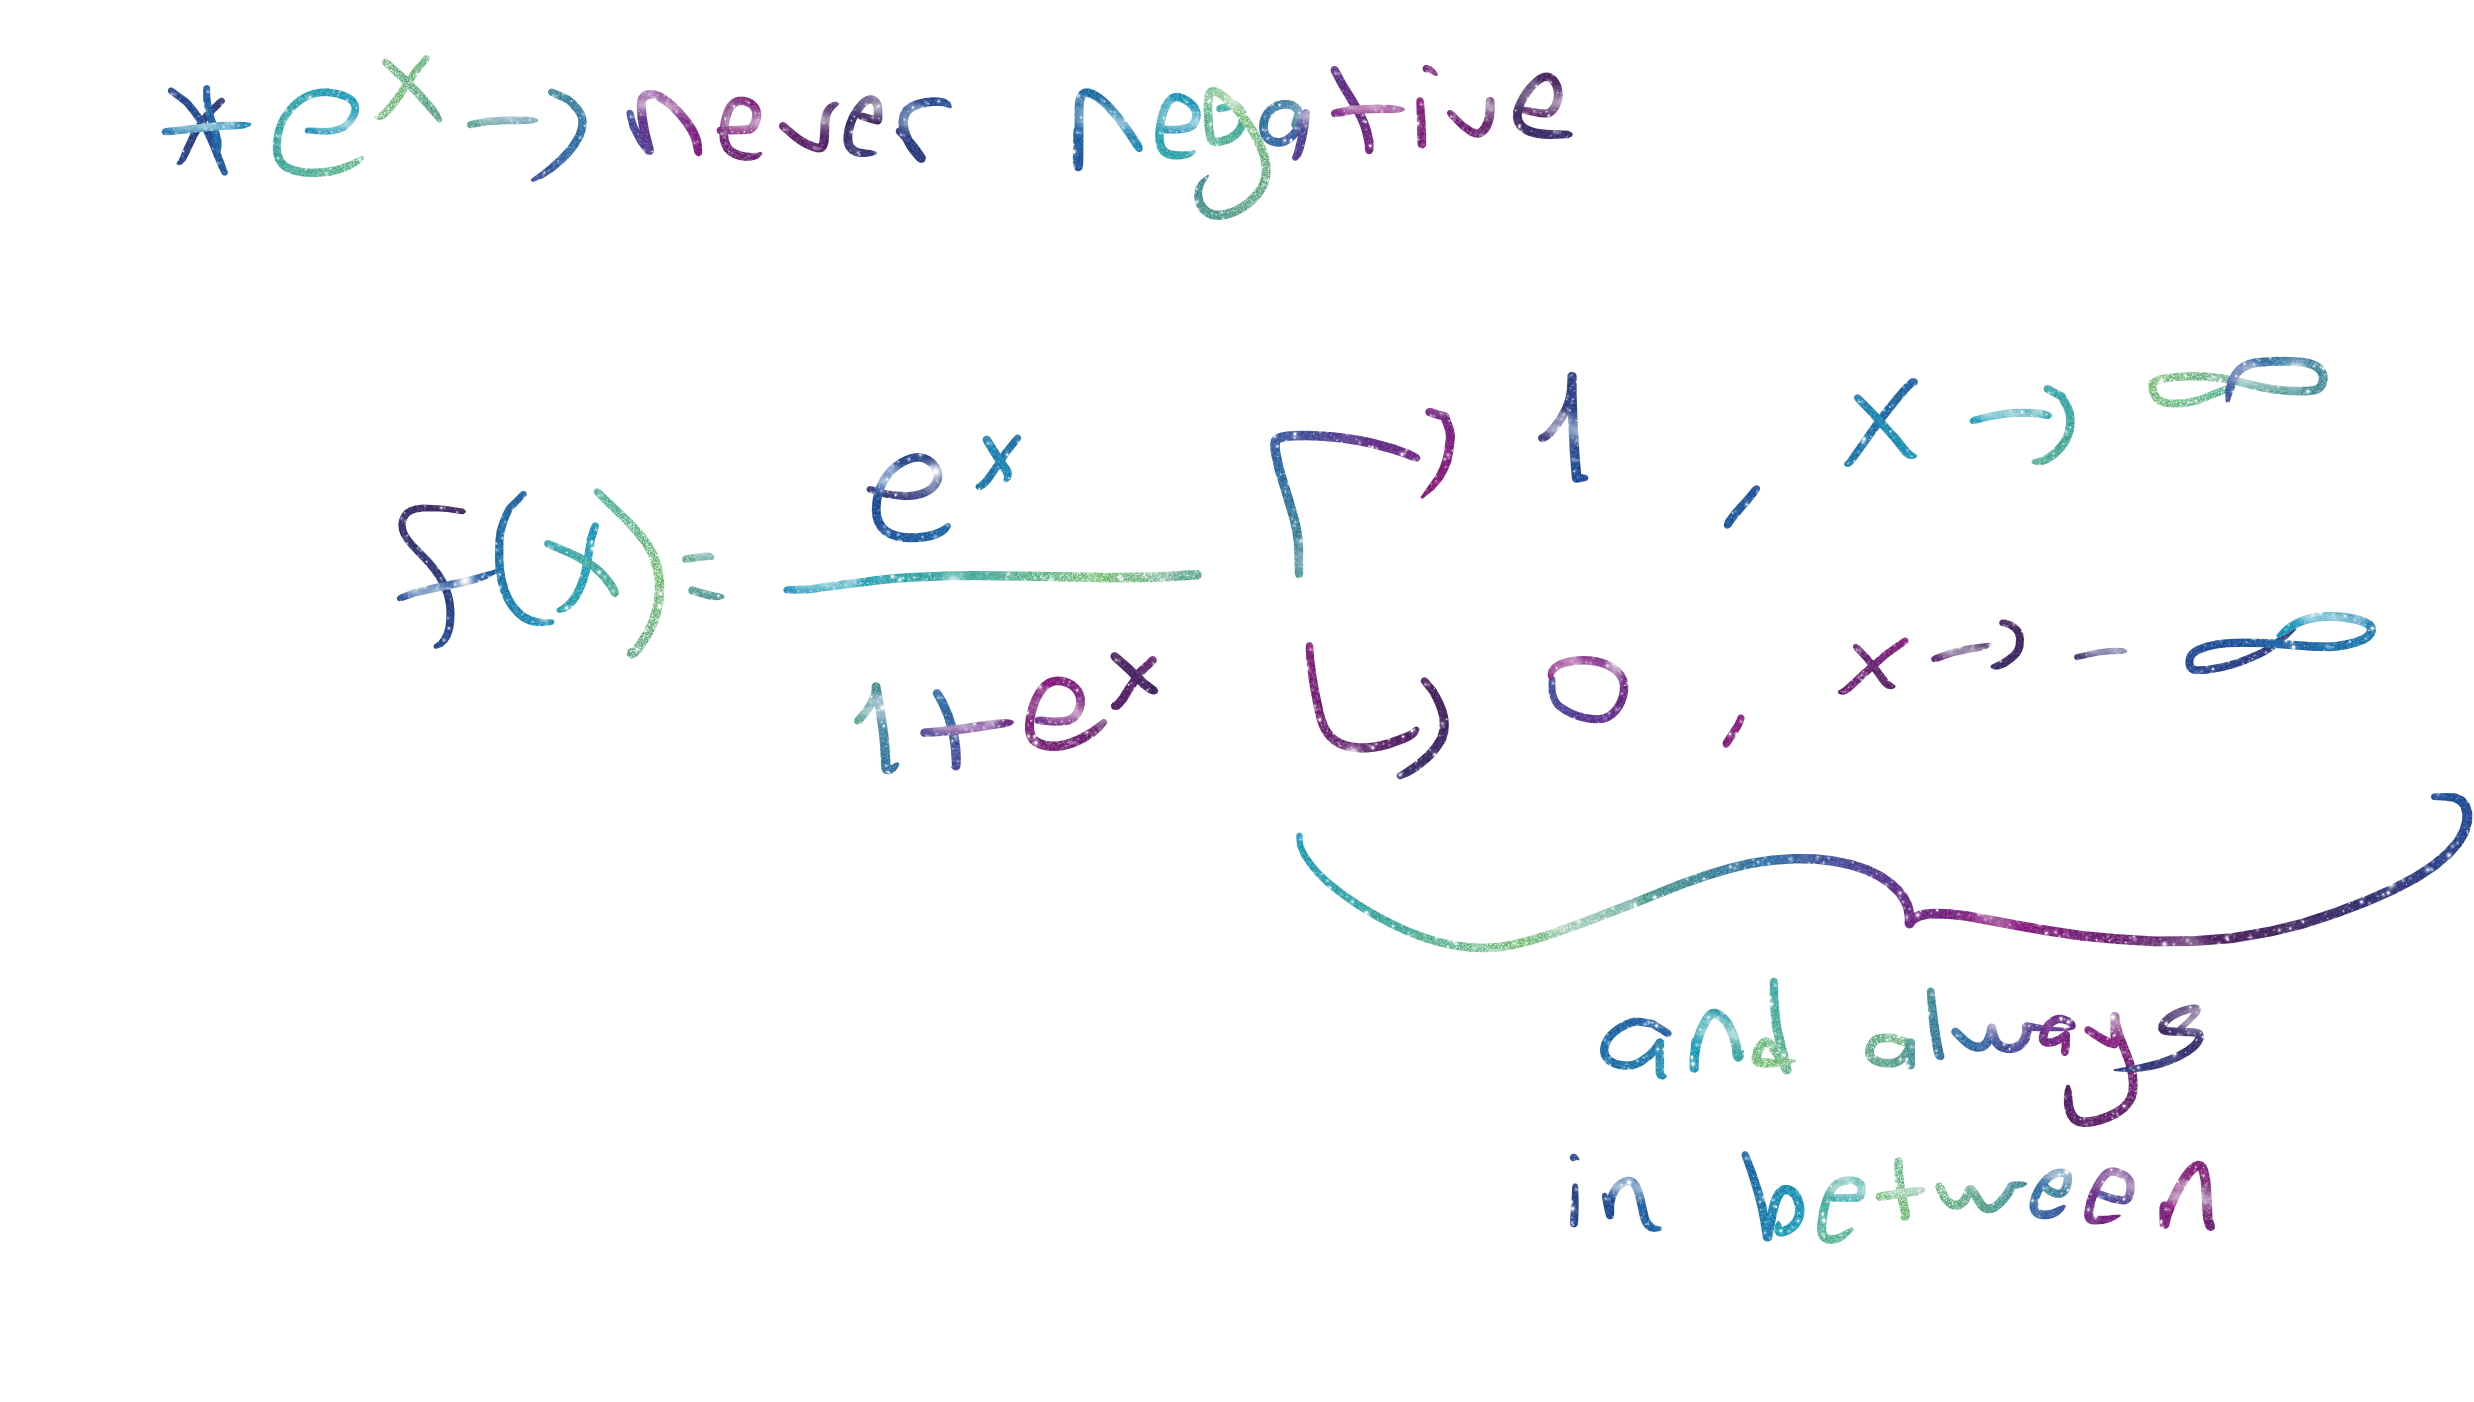

* and second one happens to be called **sigmoid**

In [534]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

* So the important point of the sigmoid is that it is mapping every numbers to a range (0,1)

In [535]:
def loss_func(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

* Now we know that no matter what prediction our model will give, our loss function will work properly

### Metric vs Loss

* This is really crucial part to understand. The **metric** is for human to understand the output of the model, but **loss** is for our model to continue learning by itself. Sometimes loss does not reflect our goal perfectly, because it has to have sensitive derivative, we need to have the effect of changing our parameters in the loss, otherwise we cannot do updates to our parameters ! Loss should respond to the small changes in our parameters. (in accuracy as a loss function case, loss is changing only when our prediction changes, so it is not sensitive to small changes in parameters, that is not what we are aiming for). But note that, even if I said sometimes it is not the ideal one to reflect how well we are doing (like accuracy being more accurate representation of our goal, but bad choice for loss function), it should be reflect how we are doing, otherwise it would be irrelevant thing, and our model cannot learn from optimizing it. But sometimes they overlap and can be same thing,  like mean square error.

* Metric is the real deal. The star of the show, or whatever you want to call it, but know that it should be the thing that you really want to improve. So focus on this to see how good your model is rather than loss. Loss is for your model not for you. (as you might have guest, the choice of loss function and metric is very very crucial step in learning)

### Gradient for single item or batch?

* Now we have a reasonable loss function, we will update. But how?

* Should we calculate our loss in each item seperately, and update for each item in our dataset, or should we calculate loss for whole dataset then calculate the mean then update our weights? 

* Calculating loss for just single item is not informative. It will only tell us how to adjust our weights to do well on that item. But is this really what we want ? We want to make good prediction in all of our data, so we need to calculate gradient according to information comming from various items. If we do that we will end with instable and imprecise gradient

* You can think as averaging gradient vector across multiple items as finding a update vector that will result in smaller loss across those items as we used their information too (gradient vector is not the direction that makes our loss smaller, opposite direction of the gradient vector is that direction)

* At the other end, calculating with all items will take a long time. At that time we can do update with smaller item size and most probably end up better place

* So we will use average loss for few items. We will feed our data to our model in **batch**es, the number of items in batches is called **batch size**. If we choose our batch size big, gradients will be more accurate but we will loss some speed. So choosing a batch size is an important decision.

* Also GPU accelerates matrix multiplication and if we do that in batches  rather than individual items it will boost model's speed

### Creating Dataloader

* So we need a tool to call multiple items at once at the start of the trainig loop

* So we will have batches from our data, we will implement DataLoader for that task

#### Yield

In [536]:
def f(x):
    for i in range(x):
        yield i

In [537]:
t1 = f(5)

In [538]:
next(t1)

0

In [539]:
for i in f(5):
    print(i)

0
1
2
3
4


#### Creating DataLoader

In [540]:
t = torch.tensor([1,2,3,4])

In [541]:
t.shape

torch.Size([4])

In [542]:
torch.randperm(t.shape[0])

tensor([1, 3, 0, 2])

In [543]:
train_x.shape[0] # 6352 different images

6352

In [544]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

### Trying our DataLoader

In [545]:
a = torch.tensor([1,2,3,4,5])

In [546]:
b = torch.tensor([10, 20, 30, 40, 50])

In [547]:
c = Dataset(a,b)

In [548]:
dl_c = DataLoader(c, 2)

In [549]:
# It does not give batch size of 2 everytime
list(dl_c)

[(tensor([1, 2]), tensor([10, 20])),
 (tensor([4, 5]), tensor([40, 50])),
 (tensor([3]), tensor([30]))]

## Writing Training Loop

We will do: (we will do same steps like initializing again for the sake of putting everything in a same place, but actually we initialized weights and bias above so we don't actually initialize them again)

1) Initialize our weights and biases (parameters)

2) Calculate our predictions with those parameters

3) Calculating Loss according to our predictions

4) Updating our parameters according to gradient of our loss

5) Loop through step 1-4 until you have desired result

(we will be doing these steps in batches)

In [550]:
w = init((28*28,1))

In [551]:
b = init(1)

In [552]:
train_dl = DataLoader(ds_train, bs = 512)

In [553]:
xb, yb = next(iter(train_dl))

In [554]:
xb.shape, yb.shape

(torch.Size([512, 784]), torch.Size([512, 1]))

In [555]:
valid_dl = DataLoader(ds_valid, bs = 512)

In [556]:
xb, yb = next(iter(valid_dl))

In [557]:
xb.shape

torch.Size([512, 784])

#### Grabbing few items and running through these steps to try

In [558]:
dl_try = DataLoader(ds_train, bs = 10)

In [559]:
b1 = next(iter(dl_try))

In [560]:
b1

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), tensor([[1],
         [1],
         [0],
         [1],
         [1],
         [1],
         [0],
         [0],
         [1],
         [0]]))

In [561]:
xb, yb = b1

In [562]:
xb.shape

torch.Size([10, 784])

In [563]:
yb.shape

torch.Size([10, 1])

In [564]:
# We will calculate our predictions using xb
preds = linear_layer(xb)
preds.shape

torch.Size([10, 1])

In [565]:
preds

tensor([[ -0.3430],
        [ -9.2110],
        [-11.7060],
        [-19.0030],
        [ -5.5211],
        [  5.5293],
        [-14.2517],
        [-17.6612],
        [ -4.2537],
        [ -4.1812]], grad_fn=<AddBackward0>)

In [566]:
loss = loss_func(preds, yb)
loss

tensor(0.4586, grad_fn=<MeanBackward0>)

In [567]:
loss.backward()

In [568]:
# shape of w and w.grad are same
w.shape, w.grad.shape

(torch.Size([784, 1]), torch.Size([784, 1]))

In [569]:
b.shape, b.grad.shape

(torch.Size([1]), torch.Size([1]))

In [570]:
b.grad

tensor([-0.0250])

#### Accumulated Gradient

In [571]:
preds = linear_layer(xb)

In [572]:
loss = loss_func(preds, yb)

In [573]:
loss.backward()

In [574]:
# We did the same thing but gradient has changed, why? Because PyTorch's default is accumulated gradient (explain)
# We need to zero out the gradients because loss.backward() calculates and add gradient to the existing ones
b.grad

tensor([-0.0500])

* So we need to zero the grads like:

In [575]:
# zero_() is inplace
w.grad.zero_()

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [576]:
b.grad.zero_()

tensor([0.])

* PyTorch is tracking all the operatins we are doing to tensors that requires grad. So for not to confuse Pytorch, we need to tell it it should not track changes when we are updating. If we assign data attribute of a tensor, PyTorch will not track those changes, it will only update data of the tensor

* Our model is trying to make prediction of images of 3 as close as possible to 1, and 0 for images of 2. And sigmoid is maping our predictions to (0,1), so we can say that the values that are closer to 1 is more probably images of 3. So we will choose 0.5 as a threshold. (But if we do not design our loss function to deal specifically for false positives etc, we cannot expect it to fix them by itself, so we can design loss function according to it and we can also try to change threshold to see how it is changing)

* In our previous model (without mapping between 0 and 1) we chose our threshold to be 0 since that was a middle point in the output space that has a range (-∞,+∞). But we applied it to sigmoid so it has changed.

In [577]:
def accuracy(preds, actuals):
    preds = preds.sigmoid()
    correct = (preds > 0.5) == actuals
    return correct.float().mean()

In [578]:
xb, yb = next(iter(train_dl))

In [579]:
xb.shape

torch.Size([512, 784])

In [580]:
w.shape

torch.Size([784, 1])

In [581]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [582]:
# params is list of variables that our model will update
def train(model, params, lr):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        for p in params:
            p.data = p.data - p.grad * lr
            p.grad.zero_()
        

* Explain what the epoch is

#### Training our Model 1 epoch

In [583]:
validation_acc(linear_layer)

0.5921875238418579

In [584]:
lr = 1
params = w, b
train(linear_layer, params, lr)

In [585]:
validation_acc(linear_layer)

0.783203125

* It has imporoved !

#### More generic train function

In [586]:
# params is list of variables that our model will update
def train(model, params, lr, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            for p in params:
                p.data = p.data - p.grad * lr
                p.grad.zero_()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))
        

In [587]:
train(linear_layer, params, lr, epochs= 10, valid_epoch=2)

0.8500000238418579
0.8960937261581421
0.912890613079071
0.9214843511581421
0.934374988079071


### init + linear_layer = nn.Linear

* We have seen that we can build neural network only using require_grad and matrix multiplication feature of PyTorch, but from now on we can use PyTorch Linear function to implement linear layers. nn.Linear of PyTorch initialize weigts and biases for given shape and can to matrix multiplication according to that

* So we can write our model just as:

In [588]:
w.shape

torch.Size([784, 1])

In [589]:
model_1 = nn.Linear(28*28, 1) # (input_size, output_size)

* nn.Linear class has parameters methods that will give us parameters

In [590]:
w, b = model_1.parameters()

In [591]:
w @ xb[0]

tensor([0.2137], grad_fn=<MvBackward>)

In [592]:
w.dtype

torch.float32

In [593]:
xb[0].dtype

torch.float32

In [594]:
w.shape

torch.Size([1, 784])

In [595]:
b.shape

torch.Size([1])

### Optimizer

* We will create class that does

```python
for p in params:
    p.data = p.data - p.grad * lr
    p.grad.zero_()
```

In [600]:
class Optimizer():
    def __init__(self, parameters,lr):
        self.params, self.lr = list(parameters), lr
    
    def step(self):
        for p in self.params:
            p.data = p.data - p.grad.data * self.lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [610]:
optim = Optimizer(model_1.parameters(), lr)

* Now our training function can be written as

In [612]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))
        

In [613]:
train(model_1, 10)

0.956250011920929
0.967968761920929


* We can even do more refactoring and write calculate_grad function

In [614]:
def calculate_grad(model, xb, yb):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    

In [615]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            calculate_grad(model, xb, yb)
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [616]:
train(model_1, 10, 2)

0.970703125
0.9683593511581421
0.9703124761581421
0.9671875238418579
0.9691406488418579


* We have created our own Optimizer class and PyTorch's SGD class is doing the same, so we can use that from now on

In [617]:
import torch.optim as opt

In [622]:
model_1 = nn.Linear(28*28, 1)
optim = opt.SGD(model_1.parameters(), lr)
train(model_1, 20, 2)

0.951171875
0.962890625
0.962890625
0.966015636920929
0.964062511920929
0.964062511920929
0.967968761920929
0.96875
0.967578113079071
0.967968761920929


## Non-Linearity

* To capture non-linear relations between inputs and output, we need to add non-linearity

* Stacked linear layer is the same as 1 linear layer (explain that)

* We want to deepen our network but at the same time we want it to learn different things. If we add non-linearity between layers, we are guaranteeing that it will behave differently than 1 single linear layer

* So by doing that, now we have a **universal function approximator**. As we have seen in our previous lectures, all we do in machine learning (hmm maybe more philosophically in life too) is trying to find a function that maps our inputs to outputs. Since we can think every task as a function like that, now we have a tool that can be used in all computable problems !

In [632]:
torch.tensor([-1.,2.,3.]).clamp_min(0.)

tensor([0., 2., 3.])

In [631]:
torch.tensor([-1.,2.,3.]).max(torch.tensor(0.0))

tensor([0., 2., 3.])

In [633]:
def relu(x):
    return x.clamp_min(0.0)
    

In [639]:
x = torch.arange(-20,20)

In [640]:
x

tensor([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
         -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
          8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19])

In [641]:
y = [relu(xi) for xi in x]

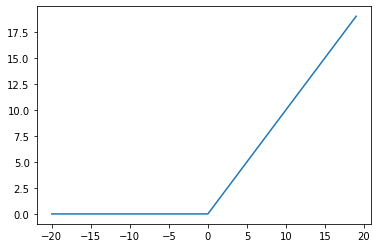

In [644]:
plt.plot(x,y);

* We will do something like this:

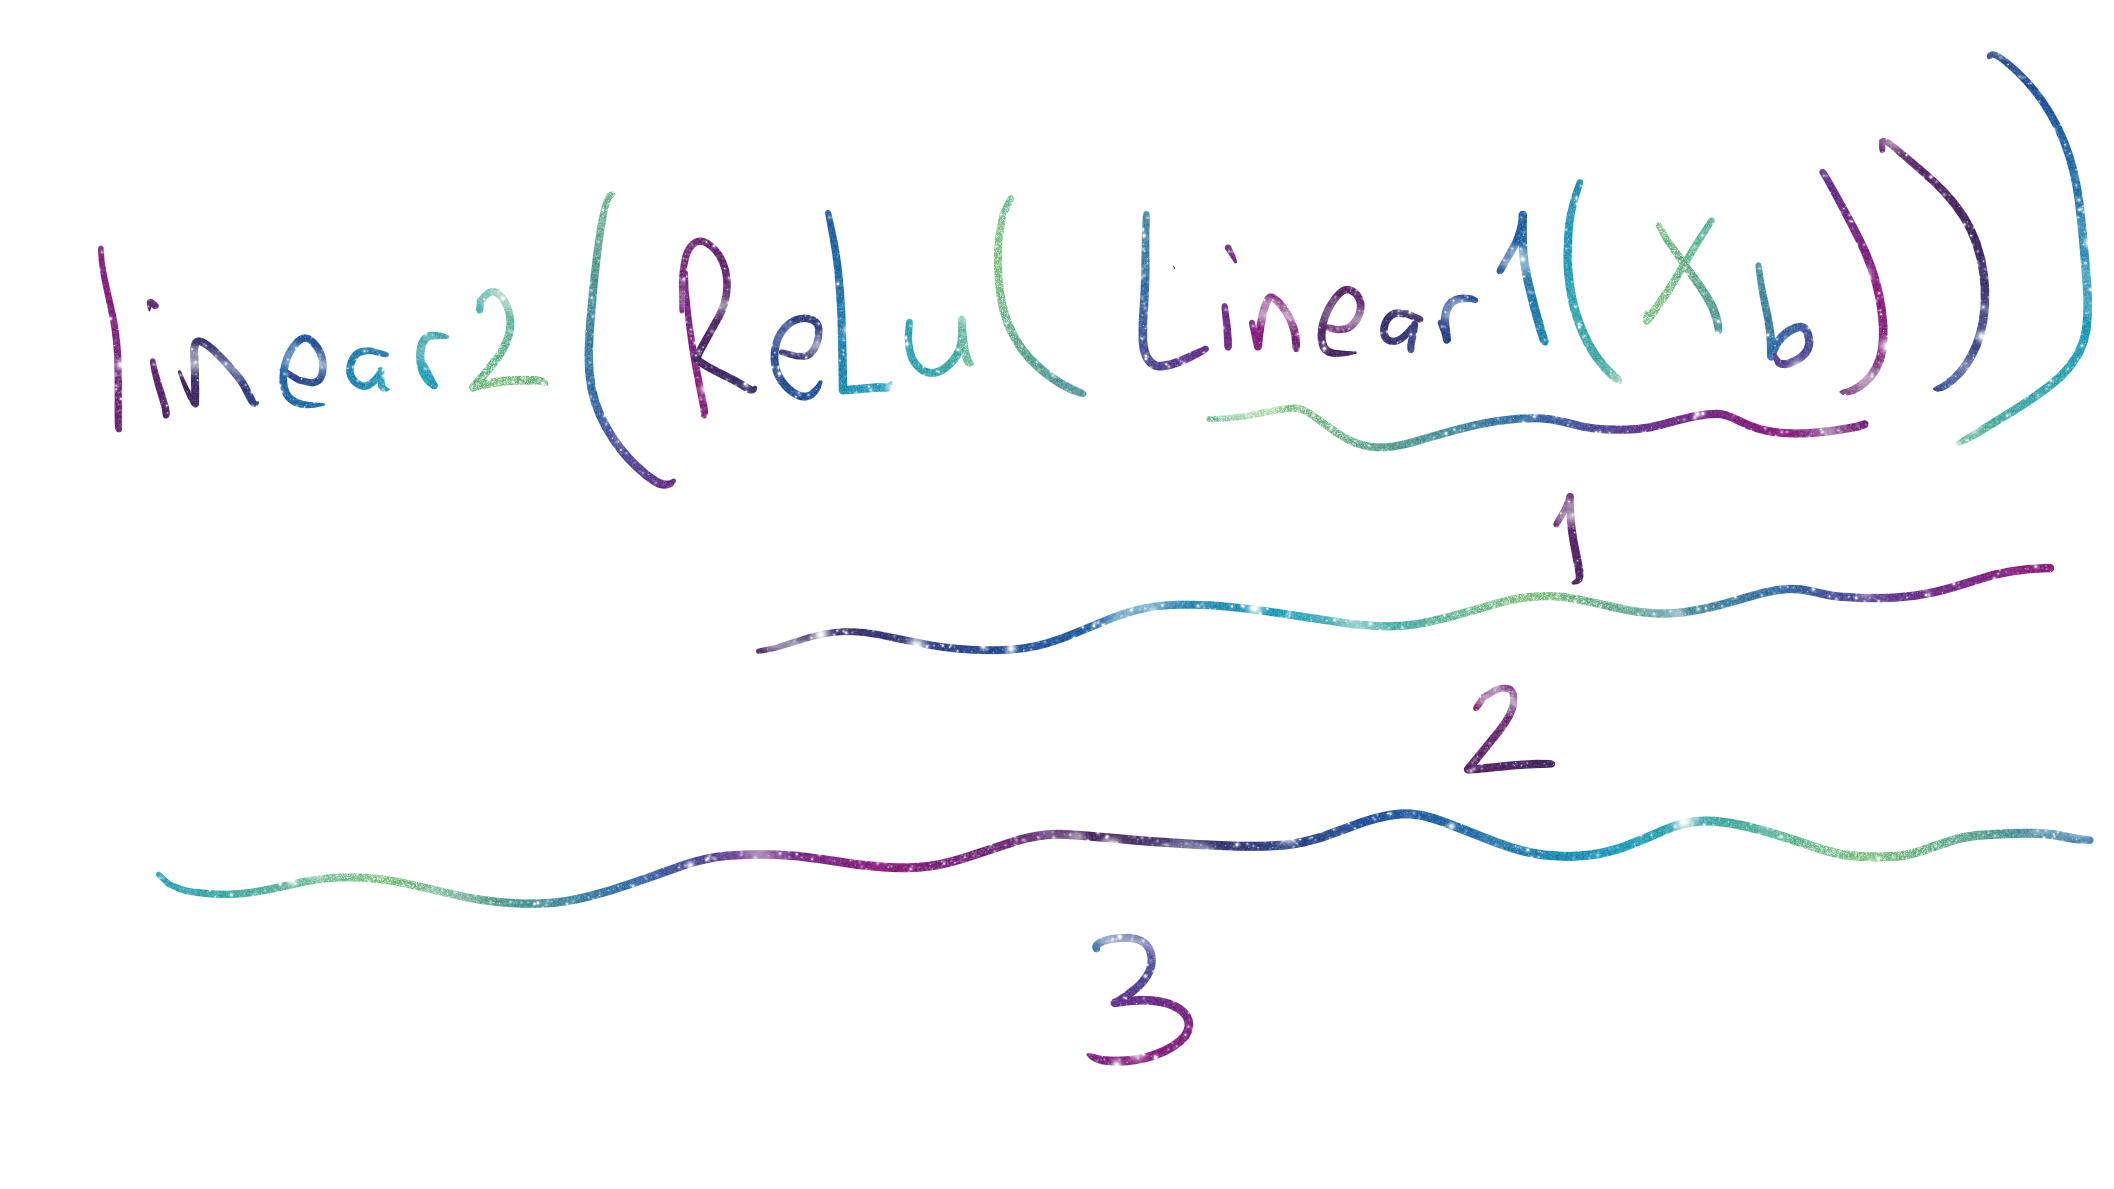

* Pytorch already has a function that exactly does that

In [686]:
model = nn.Sequential(nn.Linear(28*28, 60), 
                      nn.ReLU(),
                      nn.Linear(60,1)
                     )

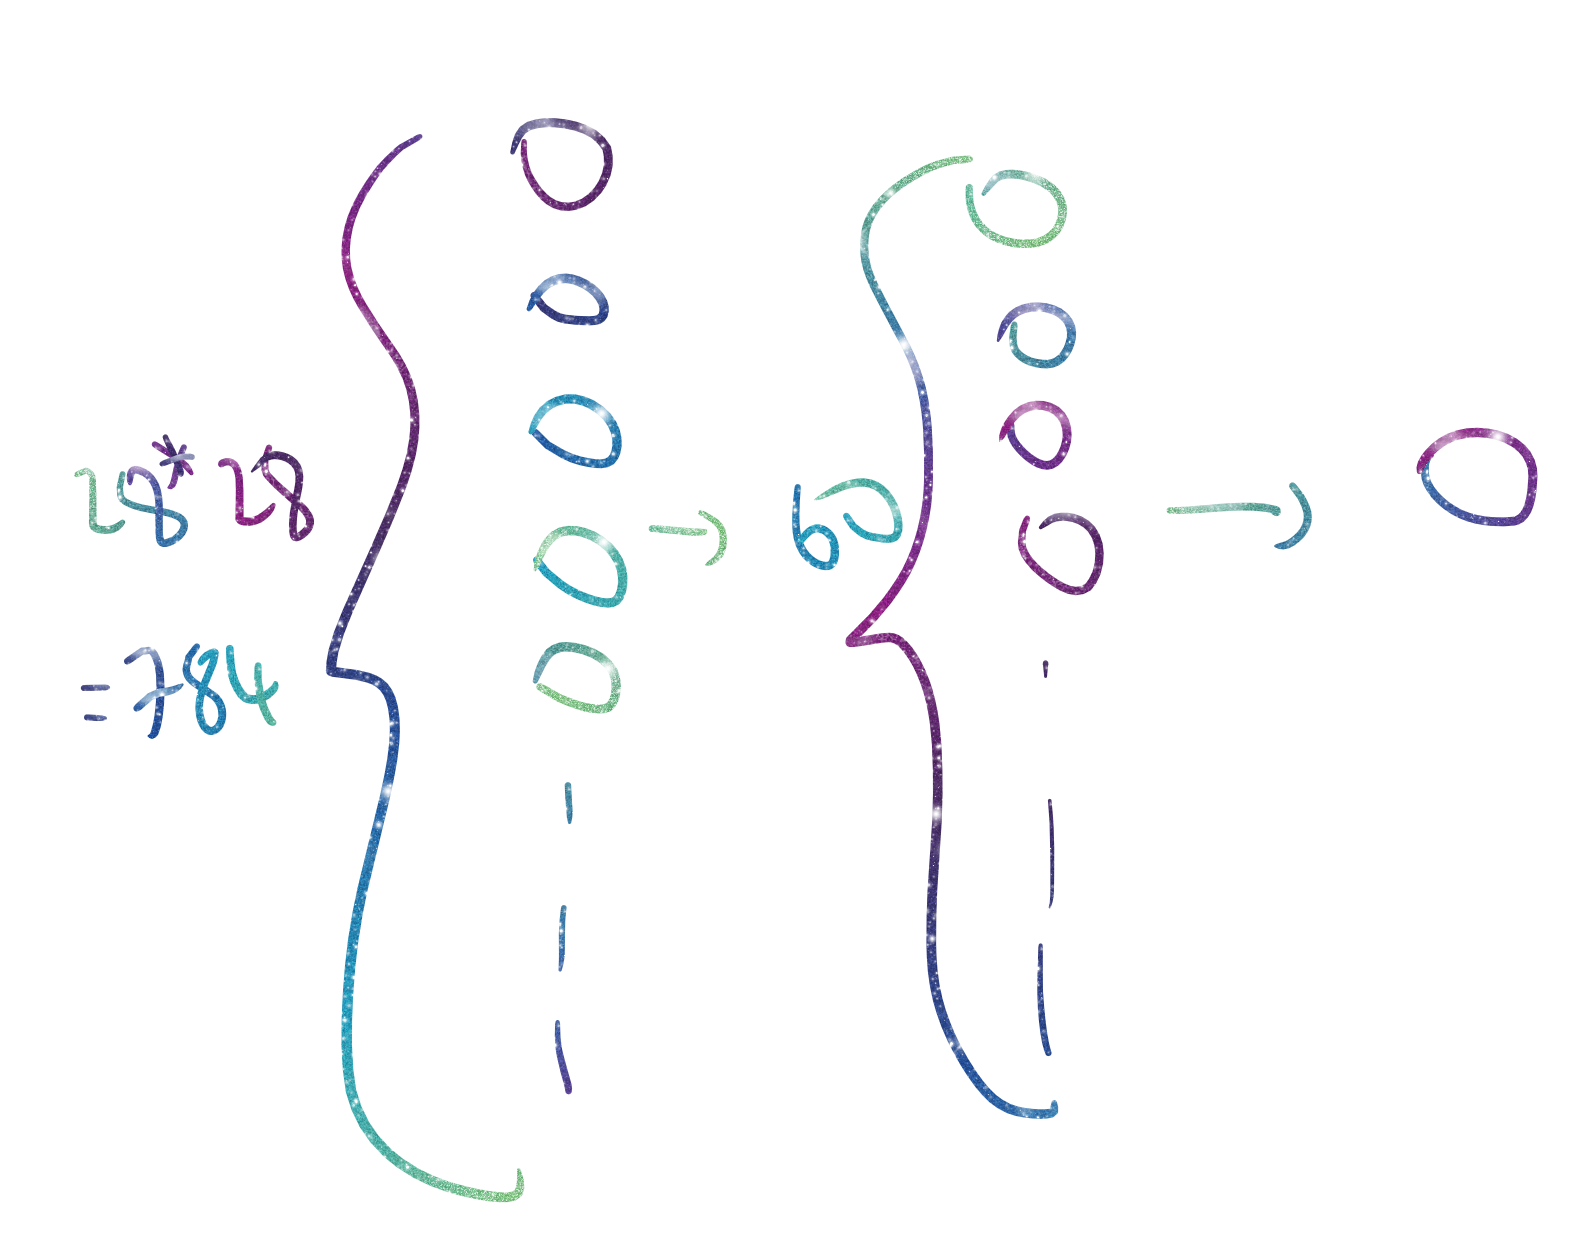

* Talk about ReLu and possible problems

In [690]:
optim = opt.SGD(model.parameters(), lr=1)
train(model, 20, 2)

0.973437488079071
0.9722656011581421
0.9730468988418579
0.97265625
0.9703124761581421
0.963671863079071
0.962109386920929
0.9703124761581421
0.970703125
0.9703124761581421


### So That was all that is to be a Neural Network actually

* Having Loss function and updating parameters according to that and adding non-linearity to have variation to capture non-linear relations are what neural networks are

* With NN we have a tool that can solve any problem

## scandir

* Scandir gives us an iterator that we can iterate that will give us the properties of the folder

In [18]:
list(os.scandir("."))

[<DirEntry '.ipynb_checkpoints'>,
 <DirEntry 'data'>,
 <DirEntry 'deneme.ipynb'>,
 <DirEntry 'deneme2.ipynb'>,
 <DirEntry 'dl_1_logistic_regression-Copy1.ipynb'>,
 <DirEntry 'dl_1_logistic_regression.ipynb'>,
 <DirEntry 'figures'>,
 <DirEntry 'hmm'>,
 <DirEntry 'img_1.jpg'>,
 <DirEntry 'Lecture_1_deneme-Copy1.ipynb'>,
 <DirEntry 'Lecture_1_deneme.ipynb'>,
 <DirEntry 'neural network from scratch.ipynb'>,
 <DirEntry 'nn_1_full - Copy.ipynb'>,
 <DirEntry 'nn_1_full-checkpoint.ipynb'>,
 <DirEntry 'nn_1_full.ipynb'>,
 <DirEntry 'nn_introduction_1.ipynb'>]

In [19]:
for f in os.scandir("."):
    print(f.name)

.ipynb_checkpoints
data
deneme.ipynb
deneme2.ipynb
dl_1_logistic_regression-Copy1.ipynb
dl_1_logistic_regression.ipynb
figures
hmm
img_1.jpg
Lecture_1_deneme-Copy1.ipynb
Lecture_1_deneme.ipynb
neural network from scratch.ipynb
nn_1_full - Copy.ipynb
nn_1_full-checkpoint.ipynb
nn_1_full.ipynb
nn_introduction_1.ipynb


## Navigating through folders and reading files one by one

In [20]:
PATH

WindowsPath('data/mnist')

In [21]:
PATH/"1"

WindowsPath('data/mnist/1')

* We will create list to hold the values of the images and labels that we will read

* But we do not want to read "." files and we only want to read specific extensions

In [22]:
def _get_files(p, fs, extensions = None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [23]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e))]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [24]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

data\mnist\train\0
data\mnist\train\1
data\mnist\train\2
data\mnist\train\3
data\mnist\train\4
data\mnist\train\5
data\mnist\train\6
data\mnist\train\7
data\mnist\train\8
data\mnist\train\9


In [25]:
val_x,val_y = create_ds_from_file(PATH/"validation")

data\mnist\validation\0
data\mnist\validation\1
data\mnist\validation\2
data\mnist\validation\3
data\mnist\validation\4
data\mnist\validation\5
data\mnist\validation\6
data\mnist\validation\7
data\mnist\validation\8
data\mnist\validation\9


### Looking at the data

In [704]:
def show(img, title):
    plt.imshow(img, cmap="gray")
    plt.title(title.item())

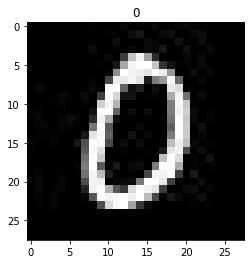

In [705]:
show(trn_x[2], val_y[2])

### View more than one image

* fig.add_subplot(221) means 2x2 grid at subplot 1

* fig.add_subplot(232) means 2x3 grid at subplot 2 etc..

* to make this plot: [link of the code](https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111)
```Python
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(221)   #top left
fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
fig.add_subplot(224)   #bottom right 
plt.show()
```  

In [706]:
def plots(ims, titles, figsize = (12, 6), rows = 2):
    fig = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    
    for i in range(len(ims)):
        sp = fig.add_subplot(rows, cols, i+1)
        # sp.axis("Off")
        sp.set_title(titles[i].item())
        plt.imshow(ims[i], cmap="gray")

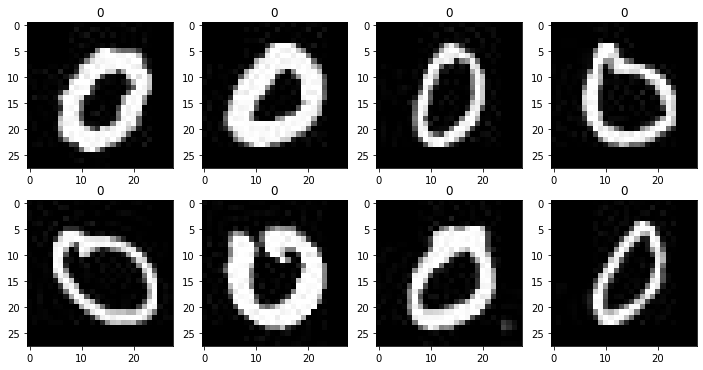

In [707]:
plots(trn_x[:8], titles=val_y[:8])

## Writing Dataset class

In [708]:
dim = trn_x[0].numel()

In [709]:
dim

784

In [710]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i].view(-1, dim).cuda(),self.y[i].cuda()

In [711]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds,self.bs = ds,bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [712]:
train_ds = Dataset(trn_x, trn_y)

In [713]:
type(train_ds[0][0])

torch.Tensor

In [714]:
valid_ds = Dataset(val_x,val_y)

In [715]:
valid_ds[0]

(tensor([[  3.,   0.,   0.,   3.,   7.,   3.,   0.,   3.,   0.,  11.,   0.,   0.,
            3.,   0.,   0.,   3.,   8.,   0.,   0.,   3.,   0.,   0.,   0.,   2.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
            5.,   0.,  12.,   0.,  16.,   0.,   0.,   4.,   0.,   2.,   8.,   3.,
            0.,   4.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
            0.,   0.,   1.,   2.,   1.,  12.,   0.,   8.,   0.,   0.,   6.,   0.,
           11.,   0.,   0.,   6.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   1.,   3.,   0.,   0.,   2.,   3.,   0.,   0.,   0.,  12.,   0.,
            0.,  23.,   0.,   0.,   0.,   0.,  11.,   3.,   0.,   0.,   4.,   0.,
            0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,
            6.,   0.,  25.,  27., 136., 135., 188.,  89.,  84.,  25.,   0.,   0.,
            3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,
            0., 

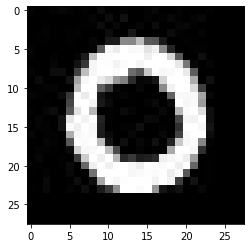

In [716]:
plt.imshow(valid_ds[0][0].view(28,28).cpu(), cmap = "gray");

In [717]:
valid_ds[0][1]

tensor(0, device='cuda:0')